dsadasdas

In [32]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A

from PIL import Image
import cv2

import os
from pathlib import Path

from data_processing.image_processing import plot_xywhn_annotated_image_from_file, plot_xywhn_annotated_array_from_df

IMAGES_DIR = "./images"
ANNOTATIONS_DIR = "./annotations"
OUTPUT_DIR = "./output"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def read_yolo_annotations(annotations_path: str):
    try:
        bboxes = pd.read_csv(annotations_path, names=['label', 'x', 'y', 'w', 'h'], sep=' ')
    except:
        return []

    return bboxes[['x', 'y', 'w', 'h', 'label']].values.tolist()

AAA
[[0.972078, 0.018615, 0.012987, 0.018182, 0.0], [0.981494, 0.972294, 0.012338, 0.022511, 0.0], [0.018506, 0.969264, 0.016234, 0.025108, 0.0], [0.024026, 0.015152, 0.018182, 0.011255, 0.0]]


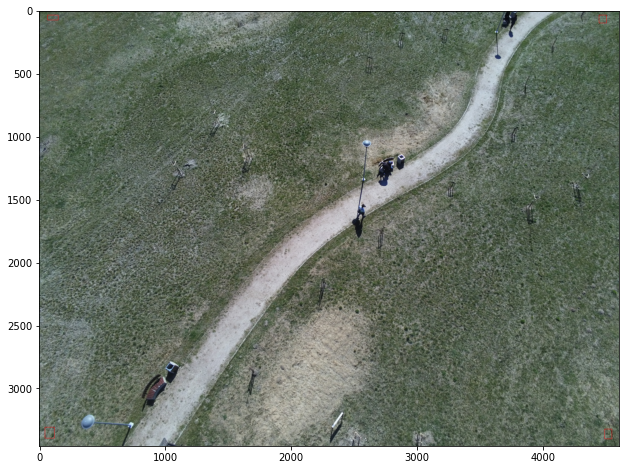

In [34]:
for file in os.listdir(IMAGES_DIR)[0:1]:
    image_path = os.path.join(IMAGES_DIR, file)
    image_filename = Path(file).stem
    annotations_path = f'{ANNOTATIONS_DIR}/{image_filename}.txt'
    if os.path.isfile(image_path):
        image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        bboxes = read_yolo_annotations(annotations_path)

print(image_filename)
print(bboxes)
plot_xywhn_annotated_image_from_file(image_path, annotations_path)

In [35]:
# OUTPUT_DIR = "./output"
# transformed_image, transformed_bboxes = augmentation_crop(image, bboxes)
# plot_xywhn_annotated_array_from_df(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB), pd.DataFrame(transformed_bboxes, columns=['xcenter', 'ycenter', 'width', 'height', 'label']))
# cv2.imwrite(f'{OUTPUT_DIR}/{image_filename}.jpg', transformed_image)

4043
0
(512, 512, 3)
Object out of cropped image - annotation deleted
Object out of cropped image - annotation deleted
Object out of cropped image - annotation deleted
4053
2907
(512, 512, 3)
Object out of cropped image - annotation deleted
Object out of cropped image - annotation deleted
Object out of cropped image - annotation deleted
26
2907
(512, 512, 3)
Object out of cropped image - annotation deleted
Object out of cropped image - annotation deleted
Object out of cropped image - annotation deleted
11
11
(512, 512, 3)
Object out of cropped image - annotation deleted
Object out of cropped image - annotation deleted
Object out of cropped image - annotation deleted


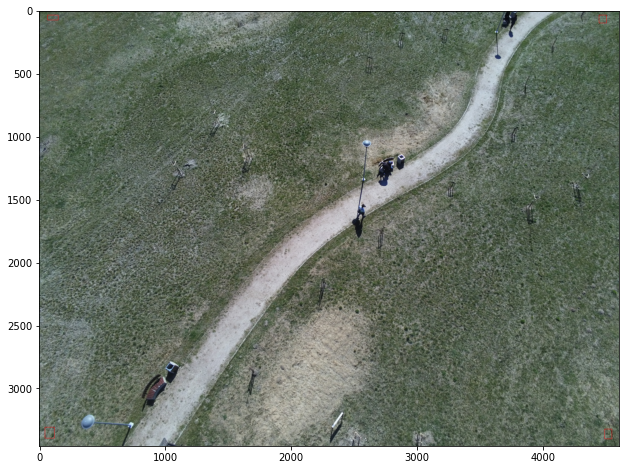

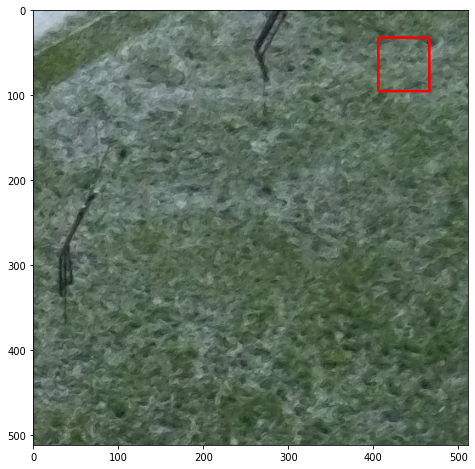

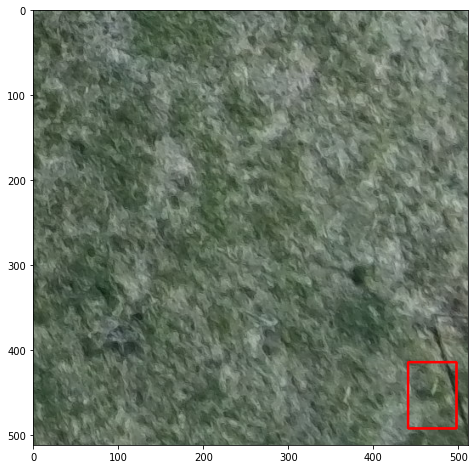

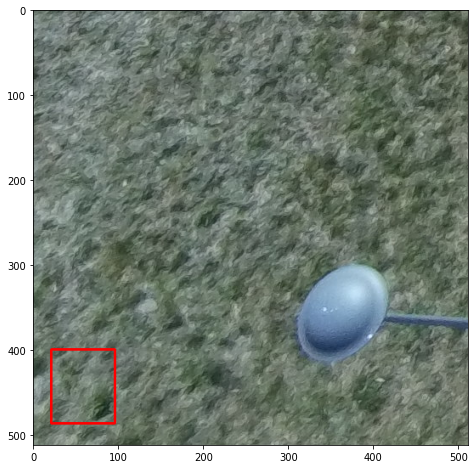

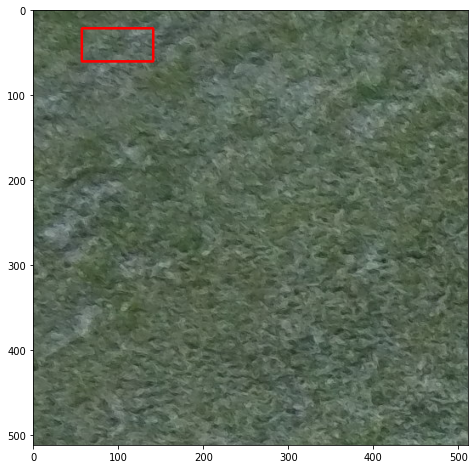

In [38]:
import random

plot_xywhn_annotated_array_from_df(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), pd.DataFrame(bboxes, columns=['xcenter', 'ycenter', 'width', 'height', 'label']))

def crop(img, df_annotation, new_width=512, new_height=512):
    """
    Crop image for each object

    :param img: image array
    :param df_annotation: dataframe with xywhn format annotation
    :param new_width: desired crop width
    :param new_height: desired crop height
    """
    height, width, _ = img.shape

    result_list = []

    for index, row in df_annotation.iterrows():
        sample_w = float(row['width']) * width
        sample_h = float(row['height']) * height
        x1, y1 = row['xcenter'] * width - sample_w / 2, row['ycenter'] * height - sample_h / 2
        # x2, y2 = x1 + sample_w, y1 + sample_h

        dx = random.uniform(max(0, new_width - width + x1), min(new_width - sample_w, x1))
        dy = random.uniform(max(0, new_height - height + y1), min(new_height - sample_h, y1))
        crop_x1 = int(x1 - dx)
        crop_y1 = int(y1 - dy)

        print(crop_x1)
        print(crop_y1)

        crop_img = img[crop_y1:crop_y1 + new_width, crop_x1:crop_x1 + new_height]
        print(crop_img.shape)
        #crop_img_copy = crop_img.copy()

        crop_annotation = []
        for index, row in df_annotation.iterrows():
            sample_w = float(row['width']) * width
            sample_h = float(row['height']) * height
            x1, y1 = row['xcenter'] * width - sample_w / 2 - crop_x1, row['ycenter'] * height - sample_h / 2 - crop_y1
            x2, y2 = x1 + sample_w, y1 + sample_h
            #cv2.rectangle(crop_img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

            w = sample_w / new_width
            h = sample_h / new_height
            xcenter = (x1 + (x2 - x1) / 2) / new_height
            ycenter = (y1 + (y2 - y1) / 2) / new_width

            if x2 < 0 or x1 > new_width or y2 < 0 or y1 > new_height:
                print("Object out of cropped image - annotation deleted")
                continue

            if x1 < 0 and x2 > 0:
                print("WARINING: Part of object might be out of cropped image - left side")
            if x2 > new_width and x1 < new_width:
                print("WARINING: Part of object might be out of cropped image - right side")
            if y1 < 0 and y2 > 0:
                print("WARINING: Part of object might be out of cropped image - top side")
            if y2 > new_height and y1 < new_height:
                print("WARINING: Part of object might be out of cropped image - bottom side")

            if w > 1:
                print("WARINING: Object might be wider than cropped image")
            if h > 1:
                print("WARINING: Object might be higher than cropped image")

            crop_annotation.append([xcenter, ycenter, w, h, row['label']])

        #plt.figure(figsize=(12, 8))
        #plt.imshow(crop_img_copy)

        result_list.append((crop_img, crop_annotation))

    return result_list


df_bboxes = pd.read_csv(annotations_path, names=['label', 'xcenter', 'ycenter', 'width', 'height'], sep=' ')
cropped_images_with_annotation = crop(image, df_bboxes)

for crop_img, crop_annotation in cropped_images_with_annotation:
    plot_xywhn_annotated_array_from_df(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB), pd.DataFrame(crop_annotation, columns=['xcenter', 'ycenter', 'width', 'height', 'label']))
